TECH CHALLENGE - Pos Tech FIAP

Obetivo: Modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.


Começamos importando as bibliotecas essenciais para análise dos dados.  Tais como o pandas para manipulação dos dados, Matplotlib e seaborn para visualização, Numpy para operações numéricas e diversas do scikit-learn para pré-processamento, seleção do modelo, treinamento e avaliação.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score


In [ ]:
# Carregando os dados do arquivo insurance.csv, carregando os dados no dataFrame do Pandas
dados = pd.read_csv('/content/insurance.csv')


**Conhecendo os Dados**
Para entender melhor os dados, exibimos as primeiras linhas a fim de ter uma visão incial da estrutura.

In [ ]:
# Exibindo as primeiras linhas do dataset
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# Imprimindo o número de linhas e colunas
dados.shape

(1338, 7)

In [ ]:
# Gerando estatísticas descritivas das colunas numéricas
print(dados.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [ ]:
# Verificando se temos dados nulos na fonte de dados
print(dados.isnull().sum())


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
# Verificando quais os tipos de colunas
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Tratando os dados:
Temos algumas colunas do tipo texto que precisamos tratar para que o algoritmo consiga processar

In [ ]:
# Verificando os domínios presentes nessas colunas
set(dados["sex"])

{'female', 'male'}

In [ ]:
set(dados["smoker"])

{'no', 'yes'}

In [ ]:
set(dados["region"])

{'northeast', 'northwest', 'southeast', 'southwest'}

Transformando as colunas que representam variáveis categóricas

Para as variáveis que tem somente 2 domínios, estamos usando o LabelEnconder, onde os valores serão transformados em 0 e 1 sem que tenhamos aumento da dimensionalidade dos dados.

Porém, para a variável região, que temos 4 domínios, optamos por usar o OneHotEncoder, pois assim, evitamos que tenhamos maior peso para um domínio ou outro.

In [ ]:
# Usando o LabelEncoder
labelEncoder = LabelEncoder()

# Aplicando o LabelEncoder às colunas 'sex' e 'smoker'
dados['sex'] = labelEncoder.fit_transform(dados['sex'])
dados['smoker'] = labelEncoder.fit_transform(dados['smoker'])

# A coluna region possui 4 categorais. Assim, usaremos o OneHotEncoder,
# separando cada categoria em 1 nova coluna
ohe = OneHotEncoder()
regiao = ohe.fit_transform(dados[['region']])
regiao = regiao.toarray()
regiao_labels = ohe.categories_
regiao = pd.DataFrame(regiao, columns=regiao_labels[0])
dados = pd.concat([dados, regiao], axis=1)
dados.drop('region', axis=1, inplace=True)

# Exibindo as primeiras linhas do DataFrame
print(dados.head())



   age  sex     bmi  children  smoker      charges  northeast  northwest  \
0   19    0  27.900         0       1  16884.92400        0.0        0.0   
1   18    1  33.770         1       0   1725.55230        0.0        0.0   
2   28    1  33.000         3       0   4449.46200        0.0        0.0   
3   33    1  22.705         0       0  21984.47061        0.0        1.0   
4   32    1  28.880         0       0   3866.85520        0.0        1.0   

   southeast  southwest  
0        0.0        1.0  
1        1.0        0.0  
2        1.0        0.0  
3        0.0        0.0  
4        0.0        0.0  


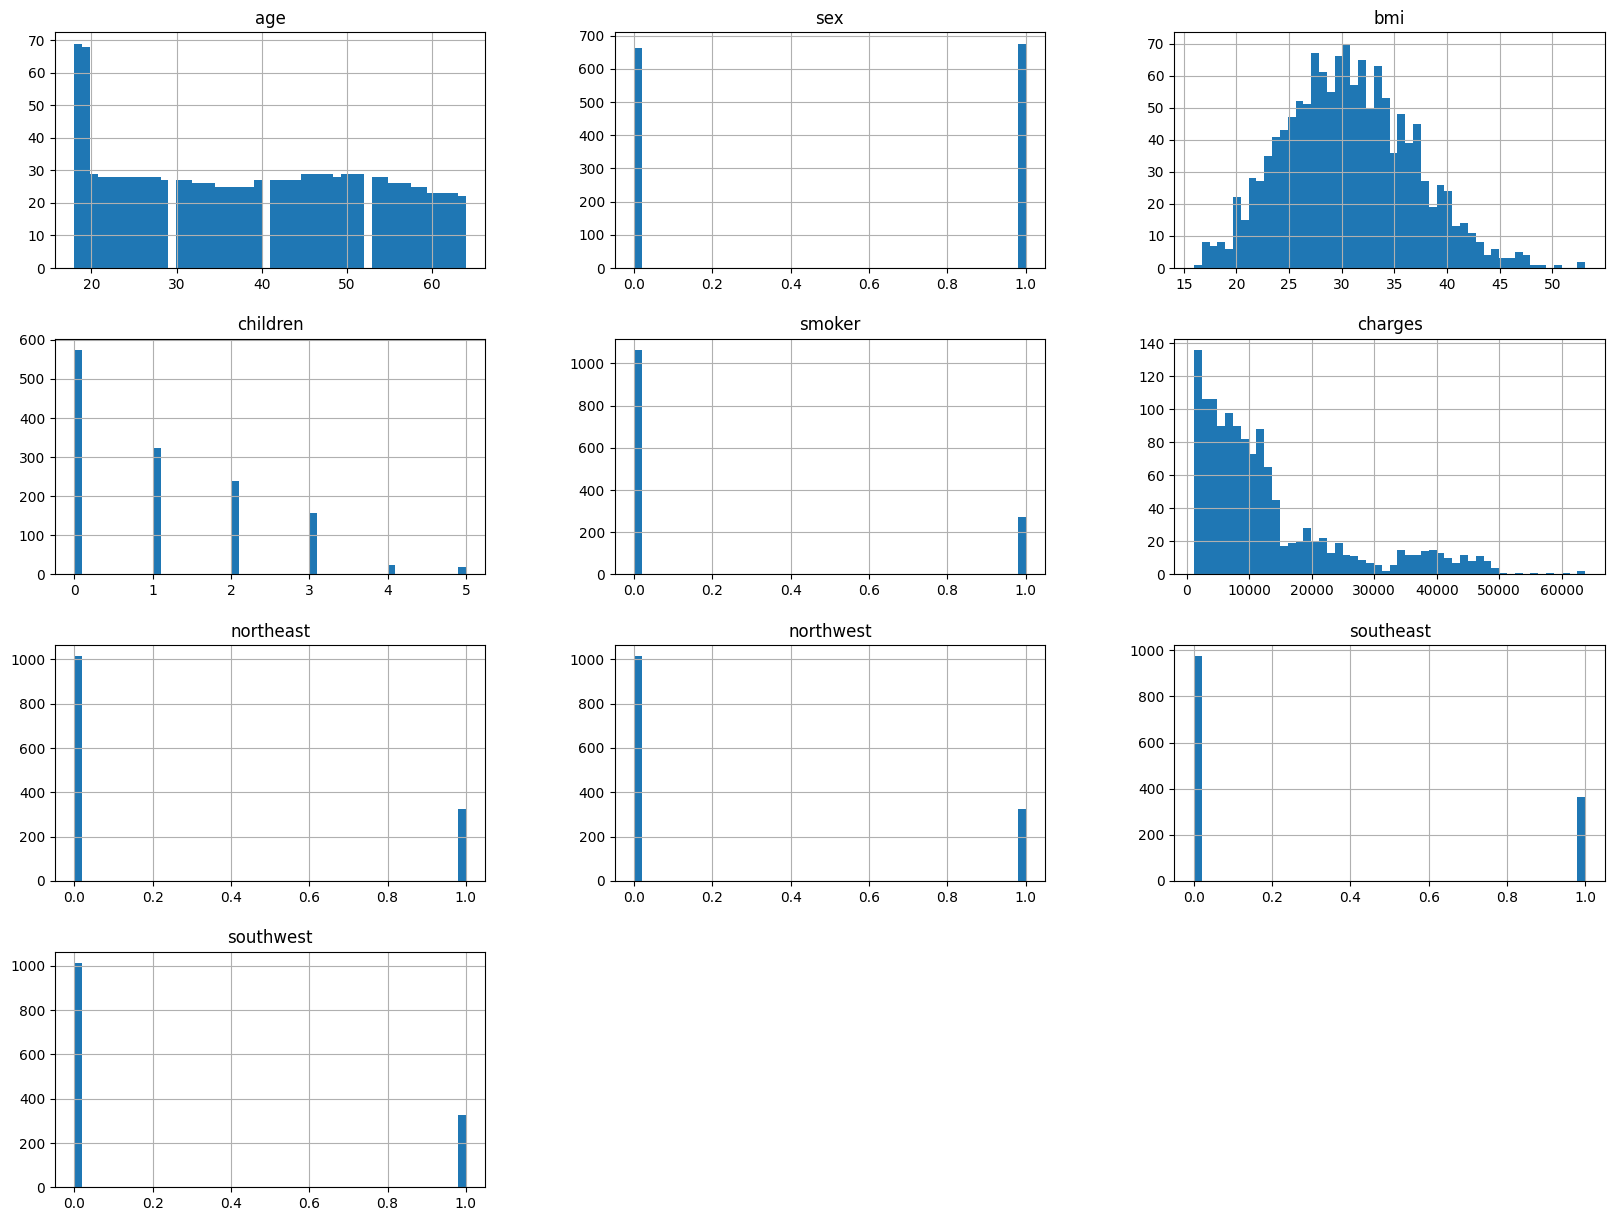

In [ ]:
#Analisando algumas distribuições com histogramas:
dados.hist(bins=50, figsize=(20,15))
plt.show()

A partir do histograma, podemos observar a distribuição dos dados.

Segue análise de cada variável:
1. Age (idade) - a distribuição da idade está relativamente uniforme, e tem uma leve concentração na faixa de 20 e 30 anos.  Isso demonstra que temos pessoas de faixas etárias diferentes, mas com um pouco mais representada por adultos jovens.

2. bmi (IMC) - aqui a distribuição parece quase normal, onde a maioria das pessoas apresentam IMC bem próximo da média, e menos pessoas com IMC muito alto ou muito baixo.  Essa informação é muito importante, pois nos ajuda a entender a saúde geral da população a ser analisada.

3. charges (custos médicos) - os dados se apresentam assimétricos para a direita.  Que pode significar que a maioria dos custos é relativamente baixa, mas têm alguns custos muito altos que influenciam a média e puxam a distribuição para a direita.

4. Children (número de filhos) - já aqui, os dados estão assimétricos à esquerda, onde a maioria das pessoas tem 0 ou 1 filho.  Famílias com mais filhos podem ter custos médicos mais altos.

Variáveis Categóricas:

5. Sex (Gênero: Masculino e Feminino) - os números de pessoas do gênero Masculino e feminino estão bem próximos, demonstrando que não temos desbalanceamento na amostra em relação a essa variável.

6. Smoker (Fumante Sim ou Não) - essa variável é muito importante, pois pode indicar impacto significativo nos custos médicos.  Na amostra analisada, podemos ver que temos mais pessoas Não Fumantes que Fumantes.

7. Region (Região) - distribuição geográfica da amostra analisada.  Pode indicar que em algumas regiões podemos ter valores mais altos que outros, devido a fatores como custo de vida, disponibilidade de serviços de saúde, etc.

                age       sex       bmi  children    smoker   charges  \
age        1.000000 -0.020856  0.109272  0.042469 -0.025019  0.299008   
sex       -0.020856  1.000000  0.046371  0.017163  0.076185  0.057292   
bmi        0.109272  0.046371  1.000000  0.012759  0.003750  0.198341   
children   0.042469  0.017163  0.012759  1.000000  0.007673  0.067998   
smoker    -0.025019  0.076185  0.003750  0.007673  1.000000  0.787251   
charges    0.299008  0.057292  0.198341  0.067998  0.787251  1.000000   
northeast  0.002475 -0.002425 -0.138156 -0.022808  0.002811  0.006349   
northwest -0.000407 -0.011156 -0.135996  0.024806 -0.036945 -0.039905   
southeast -0.011642  0.017117  0.270025 -0.023066  0.068498  0.073982   
southwest  0.010016 -0.004184 -0.006205  0.021914 -0.036945 -0.043210   

           northeast  northwest  southeast  southwest  
age         0.002475  -0.000407  -0.011642   0.010016  
sex        -0.002425  -0.011156   0.017117  -0.004184  
bmi        -0.138156  -0.135

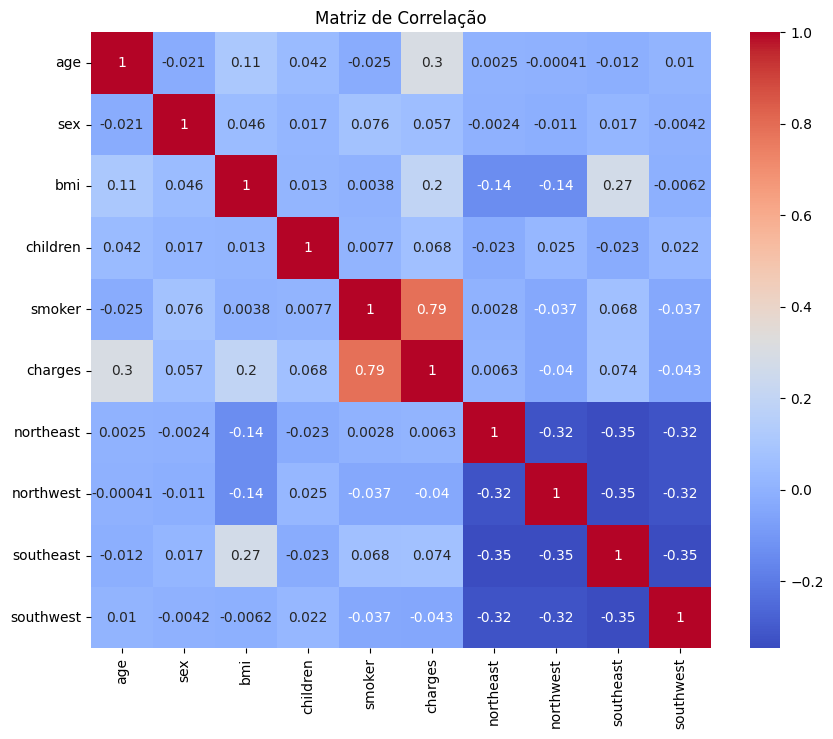

In [ ]:
# Análise de correlação entre as variáveis
matriz_correlacao = dados.corr()
print(matriz_correlacao)

# Visualizando a matriz de correlação com um heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

Analisando a Matriz de Correlação, podemos observar as seguintes relações entre as demais variáveis com os custos médicos:

Age (Idade): valor 0.3 - correlação positiva moderada - indicando que a idade tem uma influência positiva nos custos médicos, ou seja, pessoas mais velhas tendem a ter custos mais altos.

Sex (Gênero): valor 0.0057 - correlação muito fraca, ou seja, o sexo não tem influência significativa nos custos médicos da amostra analisada.

BMI (IMC): valor 0.2 - correlação positiva moderada - o que sugere que o IMC influencia positivamente, mas um pouco menos que a idade.  Pessoas com IMC mais alto tendem a ter custos médicos um pouco mais altos.

Children(Qtde de Filhos) - valor 0.0068 - correlação positiva fraca - pequena influência do número de filhos nos custos médicos.  Famílias com mais filhos podem ter custos mais altos, mas a relação não é forte.

Smoker (Fumante): valor 0.79 - Correlação positiva alta - forte influência do tabagismo nos custos médicos.  Ou seja, fumantes têm custos significamente mais altos.

Sobre as Regiões:
Northeast: 0.00063
Northwest: -0.04
Southheast: 0.074
Southwest: -0.043

Todas as regiões apresentam correlação muito fraca - indica que a região não tem influência nos custos médicos do dataset.

As variáveis mais importantes para prever os custos médicos (charges) são smoker, age e bmi, nesta ordem de importância, com base na força da correlação.

As variáveis children, sex e region parecem ter pouca ou nenhuma influência nos custos médicos.

Para o desafio, a fim de ter um modelo mais simples e com melhor interpretabilidade, vamos retirar as colunas referentes às regiões, pois são as que menos influenciam no custo médico.  

Porém, deixamos no notebook de forma parametrizada (parâmetro mantem_colunas) para que possamos testar os resultados mantendo essas colunas.


Criamos a função que será usada logo abaixo, para confirmar se temos ou não outliers significativos e a depender do modelo, retirá-los da amostra.  
Podemos observar no histograma que as variáveis charges e bmi apresentam algumas barras isoladas, que podem indicar a existência de outliers.

In [ ]:
""" Função para nos auxiliar na identificação de outliers em uma coluna do DataFrame.
    Vamos usar o método Z-score.

    Argumentos:
        dados: DataFrame.
        coluna: Nome da coluna a ser analisada.
        threshold: Limite do Z-score para considerar um ponto como outlier.

    Retorno:
        DataFrame com uma nova coluna indicando se cada ponto é um outlier.
    """
def identificar_outliers(dados, coluna, threshold=3):
  dados['outlier'] = 0  # Inicializa a coluna 'outlier' com 0
  z = np.abs((dados[coluna] - dados[coluna].mean()) / dados[coluna].std())
  dados.loc[z >= threshold, 'outlier'] = 1  # Marca outliers com 1

  # Visualizando os outliers usando um box plot.
  plt.figure(figsize=(8, 6))
  plt.boxplot(dados[coluna], vert=False)
  plt.title(f'Box Plot de {coluna}')
  plt.xlabel(coluna)
  plt.show()

  return dados

**Análise dos Boxplots**


*   charges (custo médico)
    o gráfico mostra uma assimetria à direita.  Indica que a maioria dos custos médicos é relativamente baixa, mas têm alguns custos muito altos, que puxam a distribuição para a direita.  São os mesmos outliers identificados no histograma, e podem impactar consideravelmente o modelo de regressão.
*   bmi (IMC)
    No caso do IMC o boxplot mostra uma distribuição mais simétrica, que significa que a maioria dos valores de bmi está concentrada perto da média. Tem menor quantidade de outliers, que deve ter menor impacto no modelo que na variável charges.

Conclusão, para os modelos mais sensíveis a outliers: Regressão Linear, KNN, SVR E Redes Neurais vamos retirar esses dados do dataset.



Deseja manter as colunas relacionadas a 'region' (northeast, northwest, southeast e southwest)? (Sim/Não): S


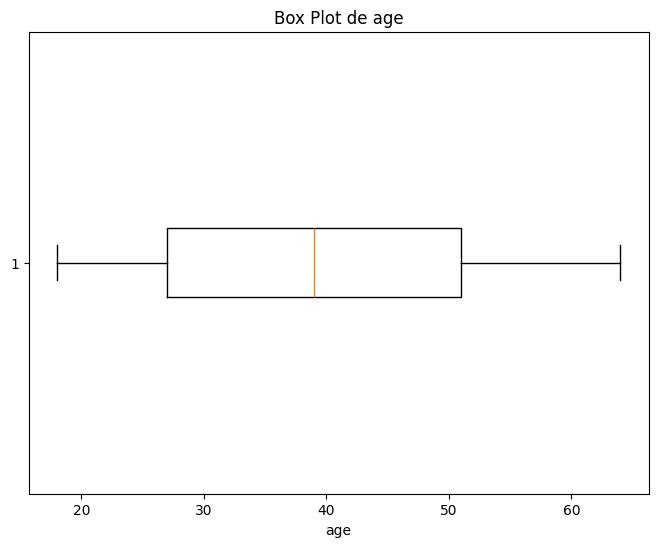

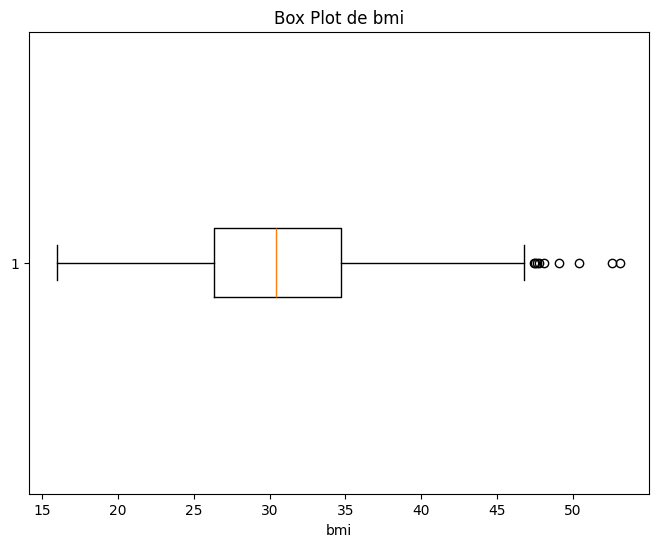

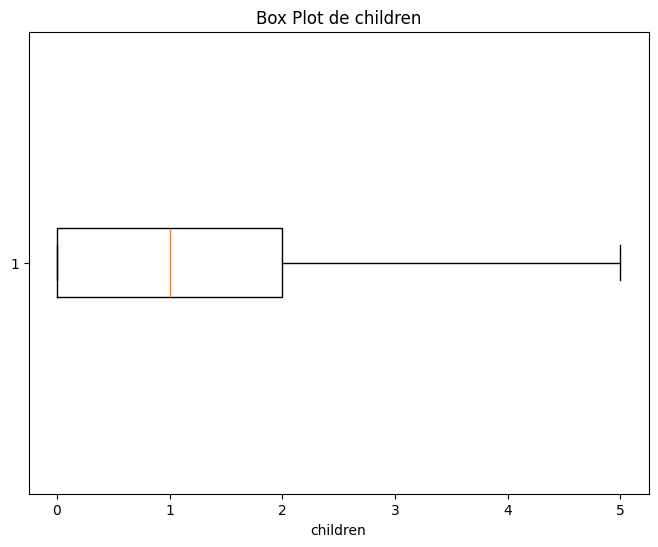

In [ ]:
'''
  Variável para listar as colunas numéricas que vamos precisar escalar
'''
colunas_numericas = ['age', 'bmi', 'children']

# parâmetro que indica se vamos ou não retirar as colunas children, sex e region
mantem_colunas = True

while True:
    resposta = input("Deseja manter as colunas relacionadas a 'region' (northeast, northwest, southeast e southwest)? (Sim/Não): ").strip().lower()
    if resposta in ("sim", "s"):
        mantem_colunas = True
        break
    elif resposta in ("não", "nao", "n"):
        mantem_colunas = False
        break
    else:
        print("Resposta inválida. Por favor, digite 'Sim' ou 'Não'.")

if not mantem_colunas:
  dados.drop(['northeast', 'northwest', 'southeast', 'southwest'], axis=1)

#identificando e excluindo os outliers
for coluna in colunas_numericas:
  dados = identificar_outliers(dados, coluna)
  # Removendo os outliers, gerando um novo dataframe que será usado nos modelos mais sensíveis
  dados_sem_outlier = dados[dados['outlier'] == 0]


# Retirada da variável Target e outlier do dataframe
X = dados.drop(['charges', 'outlier'], axis=1)
y = dados['charges']

X_sem_outlier = dados_sem_outlier.drop(['charges', 'outlier'], axis=1)
y_sem_outlier = dados_sem_outlier['charges']

# Divisão dos dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sem_outlier, X_test_sem_outlier, y_train_sem_outlier, y_test_sem_outlier = train_test_split(X_sem_outlier, y_sem_outlier, test_size=0.2, random_state=42)

# Criar o scaler
scaler = StandardScaler()

# Ajustar o scaler aos dados de treinamento e transformar os dados
X_train[colunas_numericas] = scaler.fit_transform(X_train[colunas_numericas])
X_test[colunas_numericas] = scaler.transform(X_test[colunas_numericas])

X_train_sem_outlier[colunas_numericas] = scaler.fit_transform(X_train_sem_outlier[colunas_numericas])
X_test_sem_outlier[colunas_numericas] = scaler.transform(X_test_sem_outlier[colunas_numericas])

Aqui vamos usar alguns modelos de regressão para avaliar qual seria o mais adequado para o conjunto de dados e problema proposto.

1 - Regressão Linear
Modelo de aprendizado supervisionado usado para prever um valor numérico contínuo (variável dependente) com base em uma ou mais variáveis de entrada (variáveis independentes).

A Regressão Linear foi utilizada no exercício como uma opção mais simples para prever custos médicos. Embora tenha suas limitações, como a sensibilidade a outliers e a suposição de linearidade, ela pode ser uma boa escolha para problemas com relações lineares entre as variáveis. No entanto, é importante avaliar a performance do modelo e compará-lo com outros modelos mais complexos

In [ ]:
# 1. Regressão Linear (usando dados sem outliers)
model_linear = LinearRegression()
model_linear.fit(X_train_sem_outlier, y_train_sem_outlier)
y_pred_linear = model_linear.predict(X_test_sem_outlier)

2 -  Random Forest
Modelo de aprendizado de máquina que pertence à família de algoritmos de *"ensemble learning"*, ou seja, ele combina as previsões de vários modelos individuais (nesse caso, árvores de decisão) para obter um resultado final mais preciso e robusto.

O Random Forest foi aplicado no exercício como um modelo para prever custos médicos. A busca por hiperparâmetros e a avaliação do modelo foram realizadas para garantir a melhor performance possível. O Random Forest é uma boa escolha para esse tipo de problema devido à sua alta precisão, robustez e capacidade de lidar com dados complexos.


In [ ]:
# 2. Random Forest

# Buscando os melhores parâmetros para o modelo
param_grid_rf = {
  'n_estimators': [100, 200, 300],
  'max_depth': [None, 10, 20],
  'min_samples_split': [2, 5, 10]
}
model_rf = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

print("Melhores hiperparâmetros para Random Forest:", grid_search_rf.best_params_)

# Fazer previsões
y_pred_rf = best_rf_model.predict(X_test)

Melhores hiperparâmetros para Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}


3 - Árvore de Decisão para Regressão
Modelo que prevê valores contínuos ao dividir os dados em subconjuntos com base em regras de decisão.  Essas regras são criadas a partir das features e pontos de corte que minimizam a variância da variável alvo dentro de cada subconjunto.  Visualmente, o modelo parece uma árvore, onde cada nó representa uma decisão baseada em uma feature, e cada ramo leva a um subconjunto de dados.



In [ ]:
# 3. Árvore de Decisão para Regressão

# Buscando os melhores parâmetros para o modelo
param_grid_tree = {
  'max_depth': [None, 5, 10, 15],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}
model_tree = DecisionTreeRegressor(random_state=42)  # Você pode ajustar hiperparâmetros aqui

grid_search_tree = GridSearchCV(model_tree, param_grid_tree, cv=5, scoring='r2')
grid_search_tree.fit(X_train, y_train)
best_tree_model = grid_search_tree.best_estimator_

print("Melhores hiperparâmetros para Decision Tree:", grid_search_tree.best_params_)

y_pred_tree = best_tree_model.predict(X_test)

Melhores hiperparâmetros para Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


4 - Support Vector Regression (SVR)
é um modelo de aprendizado de máquina usado para prever valores contínuos. Ele funciona encontrando um hiperplano que melhor se ajusta aos dados, com o objetivo de minimizar o erro de previsão. No SVR, o hiperplano é definido de forma que a maioria dos pontos de dados esteja dentro de uma margem de erro (epsilon) em torno do hiperplano.

In [ ]:
# 4. Support Vector Regression (SVR)  (usando dados sem outliers)

# Buscando os melhores parâmetros para o modelo
param_grid_svr = {
  'kernel': ['linear', 'rbf', 'poly'],
  'C': [0.1, 1, 10],
  'epsilon': [0.01, 0.1, 1]
}

model_svr = SVR()

grid_search_svr = GridSearchCV(model_svr, param_grid_svr, cv=5, scoring='r2')
grid_search_svr.fit(X_train_sem_outlier, y_train_sem_outlier)
best_svr_model = grid_search_svr.best_estimator_

print("Melhores hiperparâmetros para SVR:", grid_search_svr.best_params_)

# Fazer previsões
y_pred_svr = best_svr_model.predict(X_test_sem_outlier)

Melhores hiperparâmetros para SVR: {'C': 10, 'epsilon': 1, 'kernel': 'linear'}


5 - K-Nearest Neighbors (KNR) para Regressão
algoritmo de aprendizado de máquina que prevê o valor de um ponto de dados com base nos valores de seus vizinhos mais próximos no espaço de features. Em outras palavras, ele encontra os `k` pontos de dados mais similares ao ponto que se deseja prever e usa a média (ou outra medida de centralidade) dos valores desses vizinhos como a previsão para o ponto em questão.


In [ ]:
# 5. k-Nearest Neighbors (KNR) para Regressão (usando dados sem outliers)

# Buscando os melhores parâmetros para o modelo
param_grid_knr = {
  'n_neighbors': [3, 5, 7, 9],
  'weights': ['uniform', 'distance']
}
model_knr = KNeighborsRegressor()  # Você pode ajustar o número de vizinhos
grid_search_knr = GridSearchCV(model_knr, param_grid_knr, cv=5, scoring='r2')
grid_search_knr.fit(X_train_sem_outlier, y_train_sem_outlier)
best_knr_model = grid_search_knr.best_estimator_

print("Melhores hiperparâmetros para KNR:", grid_search_knr.best_params_)

# Fazer previsões
y_pred_knr = best_knr_model.predict(X_test_sem_outlier)

Melhores hiperparâmetros para KNR: {'n_neighbors': 3, 'weights': 'distance'}


6 - Redes Neurais para Regressão
modelos complexos inspirados no funcionamento do cérebro humano. Elas utilizam camadas de neurônios interconectados para aprender padrões nos dados e fazer previsões. Cada neurônio recebe entradas, realiza um cálculo e produz uma saída que é passada para outros neurônios na próxima camada. Através do ajuste dos pesos das conexões entre os neurônios durante o treinamento, a rede neural aprende a mapear as entradas para as saídas desejadas.



In [ ]:
# 6. Redes Neurais para Regressão (usando dados sem outliers)
model_mlp = MLPRegressor(hidden_layer_sizes=(100, 50),
                         max_iter=500, random_state=42)  # Ajuste a arquitetura e hiperparâmetros
model_mlp.fit(X_train_sem_outlier, y_train_sem_outlier)

y_pred_mlp = model_mlp.predict(X_test_sem_outlier)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


7 - Gradient Boosting Regressor
É um modelo de _ensemble learning_ que combina múltiplas árvores de decisão de forma sequencial, com cada árvore buscando corrigir os erros das árvores anteriores. Esse processo iterativo de aprimoramento gradual das previsões é a chave para a alta precisão do modelo.

In [ ]:
# 7. Gradient Boosting Regressor

# Buscando os melhores parâmetros para o modelo
param_grid_gb = {
  'n_estimators': [50, 100, 150],
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [3, 5, 7]
}
model_gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=5, scoring='r2')
grid_search_gb.fit(X_train, y_train)
best_gb_model = grid_search_gb.best_estimator_

print("Melhores hiperparâmetros para Gradient Boosting:", grid_search_gb.best_params_)

y_pred_gb = best_gb_model.predict(X_test)

Melhores hiperparâmetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
""" Função para cálculo das métricas de avaliação do modelo.
Argumentos:
        y_true: Valores reais.
        y_pred: Valores previstos.

Retorno: dicionário com as métricas MAE, MSE, RMSE e R2.
"""
def calcular_metricas(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

In [ ]:
# Comparação dos modelos e seleção do melhor
modelos = {
    "Regressão Linear": calcular_metricas(y_test_sem_outlier, y_pred_linear),
    "Random Forest": calcular_metricas(y_test, y_pred_rf),
    "Árvore de Decisão": calcular_metricas(y_test, y_pred_tree),
    "SVR": calcular_metricas(y_test_sem_outlier, y_pred_svr),
    "KNN": calcular_metricas(y_test_sem_outlier, y_pred_knr),
    "Redes Neurais": calcular_metricas(y_test_sem_outlier, y_pred_mlp),
    "Gradient Boosting": calcular_metricas(y_test, y_pred_gb)
}

# Criando um DataFrame vazio para armazenar os resultados
resultados_df = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'RMSE', 'R2'])

# Iterando pelos modelos e adicionar os resultados ao DataFrame
for modelo, metricas in modelos.items():
    nova_linha = pd.DataFrame([[modelo, metricas['MAE'], metricas['MSE'], metricas['RMSE'], metricas['R2']]],
                              columns=['Modelo', 'MAE', 'MSE', 'RMSE', 'R2'])
    resultados_df = pd.concat([resultados_df, nova_linha], ignore_index=True)

# Imprimindo o DataFrame
print(resultados_df)

# Escolhendo o melhor modelo com base no R2
melhor_modelo = max(modelos, key=lambda modelo: modelos[modelo]["R2"])

# Verificando o pior modelo, para fins de comparação
pior_modelo = min(modelos, key=lambda modelo: modelos[modelo]["R2"])

print(f"\nMelhor Modelo (com base no R2): {melhor_modelo}")
print(f"Pior Modelo (com base no R2): {pior_modelo}\n\n")

              Modelo          MAE           MSE          RMSE        R2
0   Regressão Linear  4238.695320  3.801533e+07   6165.657603  0.693416
1      Random Forest  2526.668665  2.009721e+07   4482.990800  0.870548
2  Árvore de Decisão  2652.025895  2.044277e+07   4521.367620  0.868322
3                SVR  5897.886536  1.287745e+08  11347.884432 -0.038535
4                KNN  3376.818533  4.579979e+07   6767.554456  0.630636
5      Redes Neurais  4106.163612  3.638724e+07   6032.183361  0.706546
6  Gradient Boosting  2455.811118  1.859772e+07   4312.507385  0.880207

Melhor Modelo (com base no R2): Gradient Boosting
Pior Modelo (com base no R2): SVR




<ipython-input-24-5956ed64efbb>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados_df = pd.concat([resultados_df, nova_linha], ignore_index=True)


In [ ]:
# Função para plotar o resultado do modelo passado como parâmetro
def plotar_resultado(modelo):
  y_test_final = y_test # Define y_test_final no início da função
  if modelo == "Regressão Linear":
      y_pred = y_pred_linear
      y_test_final = y_test_sem_outlier
  elif modelo == "Random Forest":
      y_pred = y_pred_rf
  elif modelo == "Árvore de Decisão":
      y_pred = y_pred_tree
  elif modelo == "SVR":
      y_pred = y_pred_svr
      y_test_final = y_test_sem_outlier # Usa y_test_final para consistência
  elif modelo == "KNN":
      y_pred = y_pred_knr
      y_test_final = y_test_sem_outlier # Usa y_test_final para consistência
  elif modelo == "Redes Neurais":
      y_pred = y_pred_mlp
      y_test_final = y_test_sem_outlier # Usa y_test_final para consistência
  elif modelo == "Gradient Boosting":
      y_pred = y_pred_gb

  # Plotar os resultados se y_pred for válido
  if y_pred is not None:
      plt.figure(figsize=(8, 6))
      plt.scatter(y_test_final, y_pred, alpha=0.5) # Usa y_test_final aqui
      plt.xlabel('Valores Reais')
      plt.ylabel('Valores Previstos')
      plt.title(f'Valores Reais x Valores Previstos ({modelo})')
      plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Plotando o resultado do melhor e pior modelo para fins de comparação
plotar_resultado(melhor_modelo)
plotar_resultado(pior_modelo)

Para esse exercício, aplicamos vários modelos para prever o custo médico com base nas caracteristicas apresentadas no dataset, tais como idade, IMC, tabagismo, etc.

Ao analisar os resultados, usando como base, métricas de avaliação, podemos observar que o Random Forest e o Gradient Boosting Regressor foram os modelos que apresentaram os melhores resultados.

O exercício demonstrou a importância de comparar diferentes abordagens e de entender as vantagens e desvantagens de cada modelo, para auxiliar na tomada de decisão.

